# Lab 6 - DataLoaders
**Stav Rabinovich**
**208661090**


### Imports & Installations

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision
import cv2
import albumentations as A
import random 
from PIL import Image
import torch.nn.functional as F

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install -U albumentations

from albumentations import (
    Rotate, Blur, Flip, OneOf, Compose, GaussNoise, JpegCompression, InvertImg
)
from albumentations.pytorch import ToTensor

In [3]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2021-04-18 14:21:11--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-04-18 14:21:11--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.4’

MNIST.tar.gz.4          [         <=>        ]  33.20M  20.5MB/s    in 1.6s    

2021-04-18 14:21:13 (20.5 MB/s) - ‘MNIST.tar.gz.4’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw

## **PreLab**

**Pytorch Dataset**
Significant amount of the effort applied to ML algorithms develop related to data preparation. PyTorch provides tools that make data loading easier and more readable.

torch.utils.data.Dataset - abstract class representing a dataset. Custom dataset should inherit it and override:

len (returns size of the dataset.) getitem Image augmentation for classification - Deep NN require a lot of training data to obtain good results and prevent overfitting. However, it might be challanging get enough training samples. The Image augmentation is a process of creating new training examples from the existing ones. To make a new sample, you change a little bit of the original image.

In [4]:
# I'll take the trio (6, 6, 1)
# The probabilities = {Flip: 0.1 ; Rotate: 0.6 ; Blur: 0.6}.
_transform = A.Compose([A.Flip(p=0.1), A.Rotate(p=0.6), A.Blur(p=0.6)])

### **Perform Augmentation**

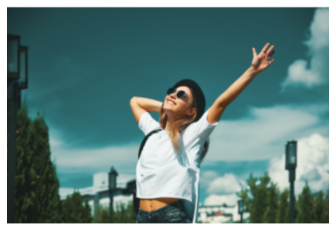

In [5]:
img = cv2.imread('../input/imagepre/imag.png') 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(img)

In [6]:
# I'll take the trio (6, 6, 1)
# The probabilities = {Flip: 0.1 ; Rotate: 0.6 ; Blur: 0.6}.
transform = A.Compose([A.Flip(p=0.1), A.Rotate(p=0.6), A.Blur(p=0.6)])

<Figure size 432x288 with 0 Axes>

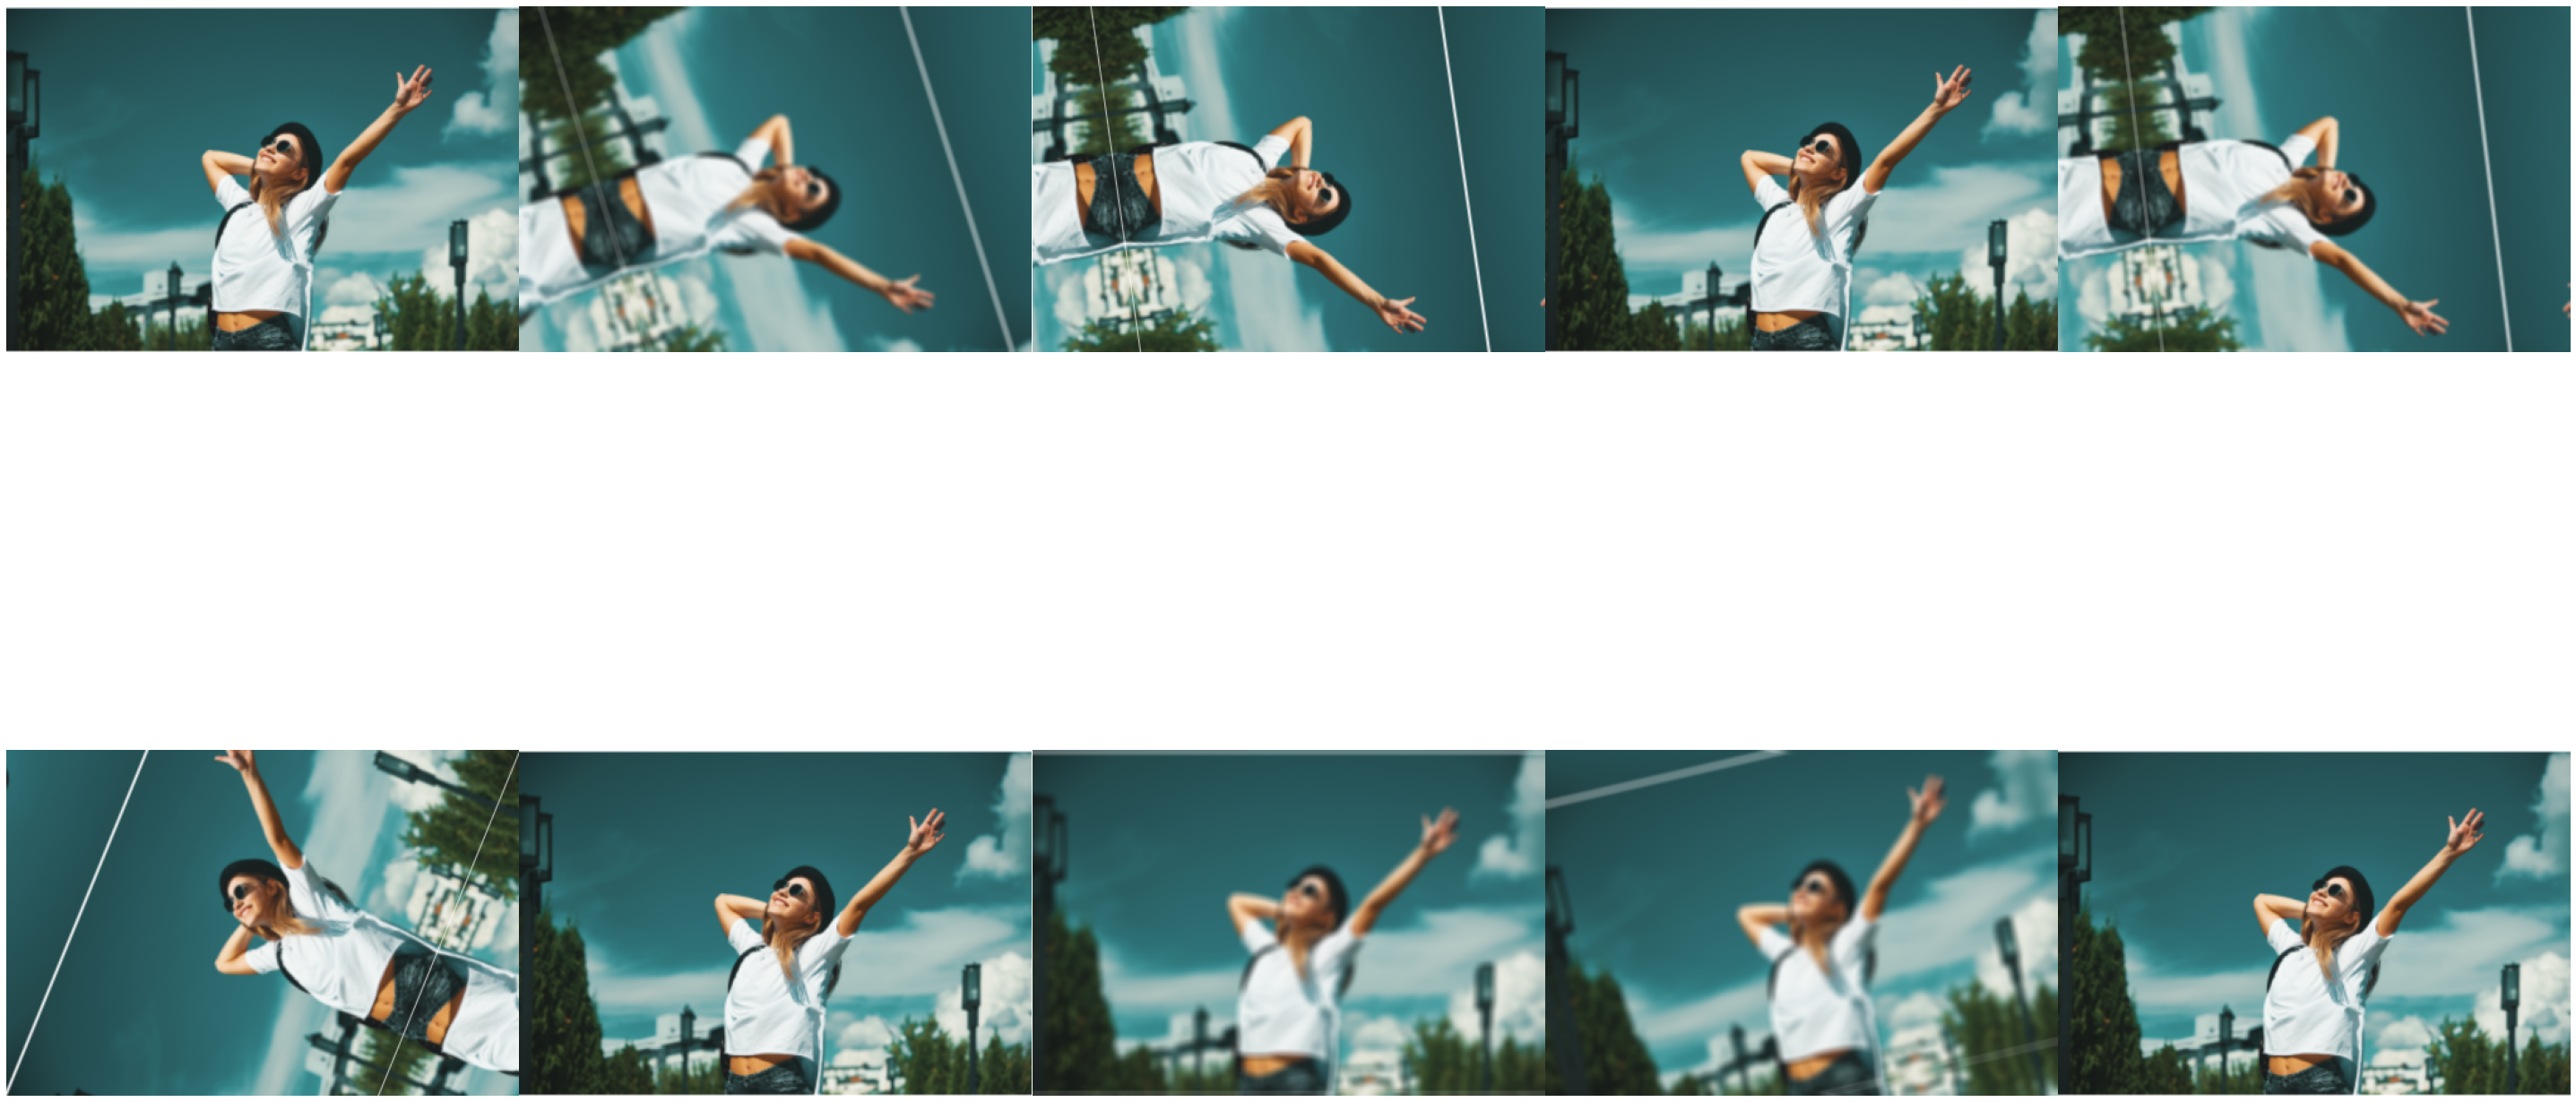

In [7]:
# Random Argumentation
plt.tight_layout()
plt.figure(figsize=(40,30))
for i in range(10):
  plt.subplot(2, 5, i+1)
  new_img = transform(image=img)["image"]
  plt.axis("off")
  plt.imshow(new_img)
plt.tight_layout(pad=1, w_pad=0.1, h_pad=0.1)
plt.show()

## **Lab**

### Import Data

In [8]:
train_set = torchvision.datasets.MNIST(root="", train=True, download=False)
test_set = torchvision.datasets.MNIST(root="", train=False, download=False)

### **Setting up transforms**

Demo image vs torch

In [9]:
mnist_transform = Compose([Rotate(10,p=0.3),
                           Blur(3,p=0.7),
                           Flip(p=0.1),
                            GaussNoise(),
                            JpegCompression(),
                            InvertImg()])

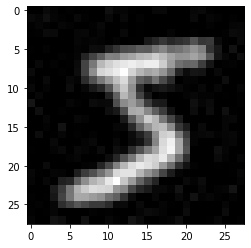

In [10]:
im = mnist_transform(image=train_set.data[0].numpy())
plt.imshow(im['image'], cmap="gray")

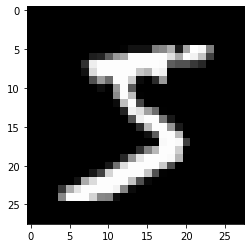

In [11]:
plt.imshow(train_set.data[0].numpy(), cmap="gray")

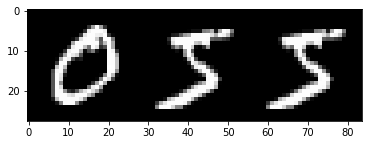

In [12]:
# New Digit
new_digit = torch.cat([train_set.data[1], train_set.data[0], train_set.data[0]], dim = -1)
plt.imshow(new_digit.numpy(), cmap="gray")

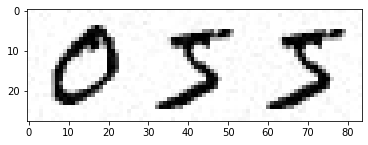

In [13]:
plt.imshow(mnist_transform(image = new_digit.numpy())['image'], cmap = 'gray')

#### **MNist Dataloader Class**

In [14]:
class MNISTDataset1(Dataset):
  def __init__(self, train_set, transforms=None):
    super(MNISTDataset1,self).__init__()
    self.x_train = train_set.data
    self.y_train = train_set.targets
    self.transforms = transforms

  def __getitem__(self,idx):
    if idx < len(self.x_train):
      img = pil2np(self.x_train[idx])
      label = self.y_train[idx]
      if self.transforms:
        img = self.transforms(image=img)['image']
      return img, label
    else:
      return -1

  def __len__(self):
    return len(self.x_train)

  def plot(self, r=5, c=5):
    x = list()
    fig = plt.figure(figsize=(8, 8))
    for i in range(1,r*c+1):
      index = random.randint(1,60000)
      tmp, t = self.__getitem__(index)
      fig.add_subplot(r, c, i)
      plt.imshow(tmp)
    plt.show()

# conver pil or torch.Tensor formnat to numpy
def pil2np(img):
  if isinstance(img, Image.Image) or isinstance(img, torch.Tensor):
    return np.array(img)
  return img

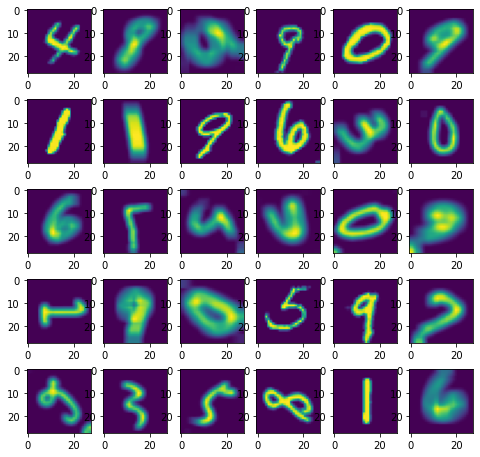

In [15]:
mnist_DS = MNISTDataset1(train_set, transform)
mnist_DS.plot(5,6)

In [16]:
BS = 3 # batch_size
mnist_dataloader = DataLoader(dataset=mnist_DS, batch_size=BS,shuffle=True)

In [17]:
next_batch = iter(mnist_dataloader)
for img, label in mnist_dataloader:
  print(label.shape)
  break

torch.Size([3])


In [18]:
batch = next(next_batch)
print(batch)

[tensor([[[  0,   0,   0,  ..., 199, 246, 220],
         [  0,   0,   0,  ...,  85,  79,  99],
         [  0,   0,   0,  ...,   0,   6,   0],
         ...,
         [  0,   0,   0,  ...,   0,  73, 206],
         [  0,   0,   0,  ...,   3,  60, 234],
         [  0,   0,   0,  ...,   0,  64, 182]],

        [[  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]],

        [[  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]]], dtype=torch.uint8), tensor([5, 9, 7])]


### MNist

In [19]:
class MNISTDataset(Dataset):
  def __init__(self, data, labels, transforms=None):
    #super(MNISTDataset, self).__init__()
    self.x = data.numpy()
    self.y = labels.numpy()
    self.transforms = transforms

  def __getitem__(self, idx):
    x = cv2.cvtColor(self.x[idx], cv2.COLOR_GRAY2RGB)# this is for alex net that ecepts picture size of 224 and 3 channels
    x = cv2.resize(x, (224,224)) 
    y = self.y[idx]
    if self.transforms:
      x = self.transforms(image=x)['image']
    #x = x[np.newaxis, :, :]
    return x, y #in fin we need to return the mask(mask its the label)

  def __len__(self):
    return len(self.x)

In [20]:
test_dataset_mnist = MNISTDataset(test_set.data, test_set.targets, mnist_transform)
test_dataloader = DataLoader(test_dataset_mnist, batch_size=100, shuffle=False, num_workers=2)
test_dataloader_run = iter(test_dataloader)

In [23]:
x_data = next(test_dataloader_run)[0].permute(0, 3, 1, 2) #[B, C, H, W] [100, 1, 224, 244], premute does reordering the shape values
x_data.shape

torch.Size([100, 3, 224, 224])

#### **AlexNet**

In [24]:
alexNet = torchvision.models.AlexNet(num_classes=100)
print(alexNet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [25]:
output = alexNet(x_data.float())
output.shape #100 images in batch, 100 classes in mnist imagenet

torch.Size([100, 100])

In [26]:
F.softmax(output, dim= -1).argmax(dim=-1) #the results wont be accurate because we didnt train the net on mnist, even if its pretrain

tensor([68, 17, 23, 95,  5, 52, 42, 59, 87, 99, 95, 26, 92, 84, 95, 95,  5, 11,
        95, 11, 60, 95, 11, 92, 52, 17, 95, 95, 95, 95, 23, 11, 89, 65, 95, 95,
        95, 17, 76,  5, 87, 23, 11, 95, 67,  1, 95, 52, 76, 95, 95, 99, 99,  5,
        59, 95, 23, 84, 59,  1, 89, 23, 76, 89, 76, 76, 95, 76, 95, 59, 52, 37,
        95, 11, 95, 23, 89, 59, 80, 23, 92, 95, 68, 76, 44, 11, 26, 45, 59, 95,
        59, 95, 95, 11, 95, 95, 76,  5, 59, 11])

## **Final Report**

#### Helping Functions

In [27]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def decode_rle(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lw, hig in zip(starts, ends):
        img[lw:hig] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def get_all_masks(masks:list):
    all_masks = np.zeros((768, 768))
    for msk in masks:
        all_masks += decode_rle(msk)
    return all_masks

def display_mask_img(img, mask):
    fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[2].axis('off')
    axarr[0].imshow(img)
    axarr[1].imshow(mask)
    axarr[2].imshow(img)
    axarr[2].imshow(mask, alpha=0.4)
    plt.tight_layout(h_pad=0.1, w_pad=0.1)
    plt.show()

##### Data path

In [28]:
path_ship = '../input/airbus-ship-detection'
path_img_train = os.path.join(path_ship, 'train_v2/')

#### **Creating new dataset class**

In [29]:
class DatasetAirbus(Dataset):
    def __init__(self, data_path, transforms=None):
        super(DatasetAirbus, self).__init__()
        self.path = data_path
        self.x_train = os.listdir(data_path) # List of the images id's.
        self.df = pd.read_csv('../input/airbus-ship-detection/train_ship_segmentations_v2.csv')
        self.masks = self.df[self.df['EncodedPixels'].notna()]
        self.transform = transforms
  
    def __getitem__(self, idx):
        id_img = self.x_train[idx]
        img = cv2.imread(self.path + id_img) # Reading the image from kaggle input.
        mask = get_all_masks(self.masks.loc[self.masks['ImageId'] == id_img, 'EncodedPixels'].tolist())
        if self.transform :
            # Pass image and masks to the augmentation pipeline
            # and receive augmented images and masks.
            transformed = self.transform(image=img, mask=mask)
            img = transformed['image']
            mask = transformed['mask']
        return img, mask
  
    def __len__(self):
        return len(self.x_train)
    
# Loading the dataset
airbus_ds =  DatasetAirbus(path_img_train, transforms=transform)

### **Examples**

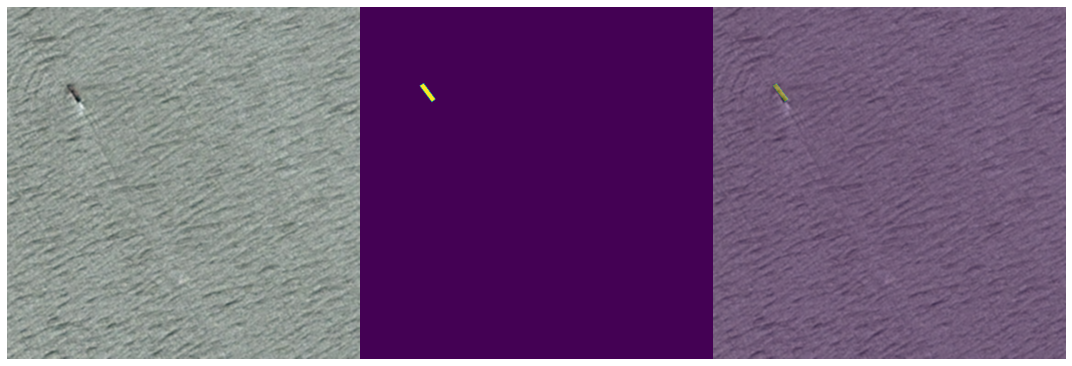

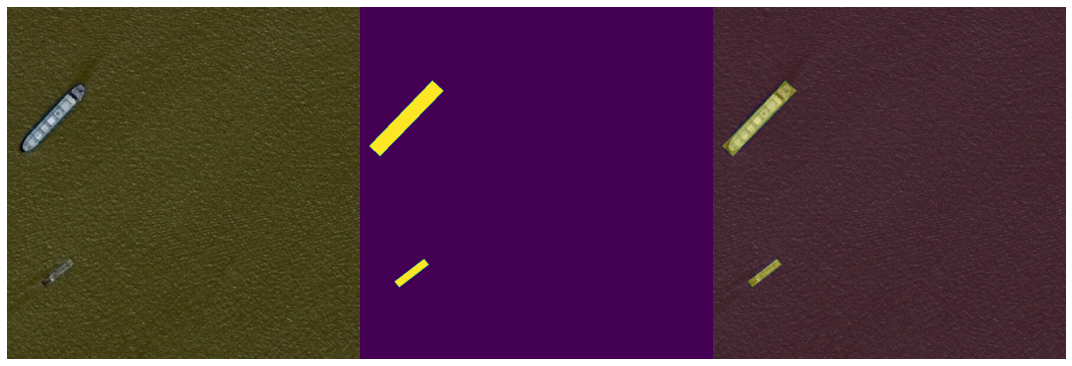

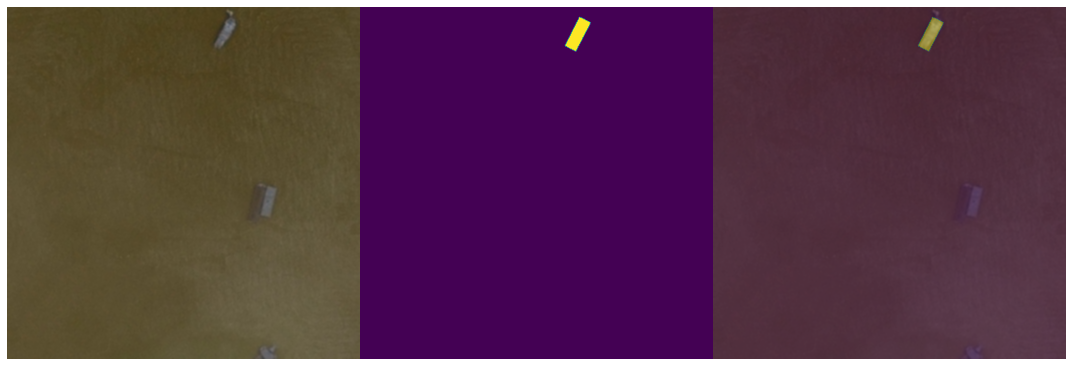

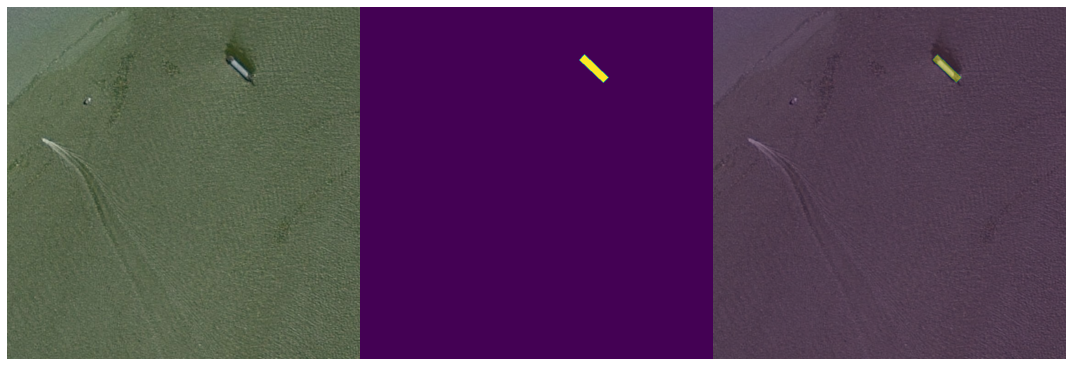

In [30]:
example_list = [130, 155, 14442, 3113]
for ex in example_list:
    img, mask = airbus_ds[ex]
    display_mask_img(img, mask)

In [31]:
# DataLoader
d_loader = DataLoader(airbus_ds, batch_size=64, shuffle=True)